
Dataset Information:
                         File Name  Rows  Columns
0  Ashvin_5Mins_NB_20_02_2025.csv  5884        6
1     Harsha_5min_NB_20_02_25.csv  9791        6


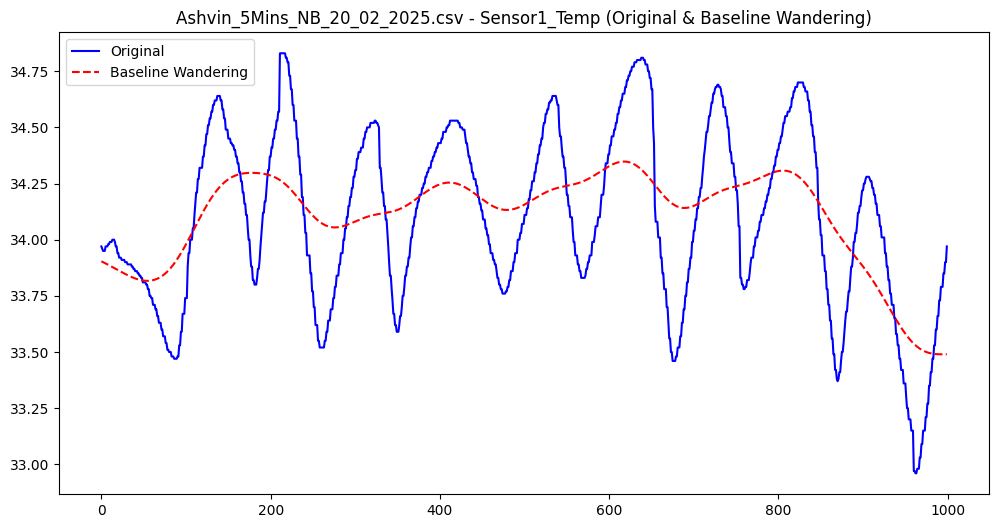

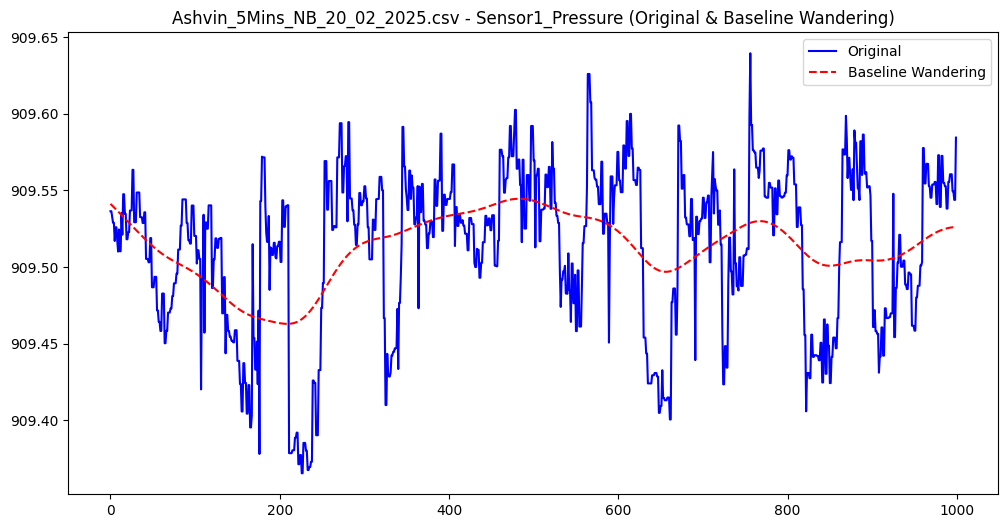

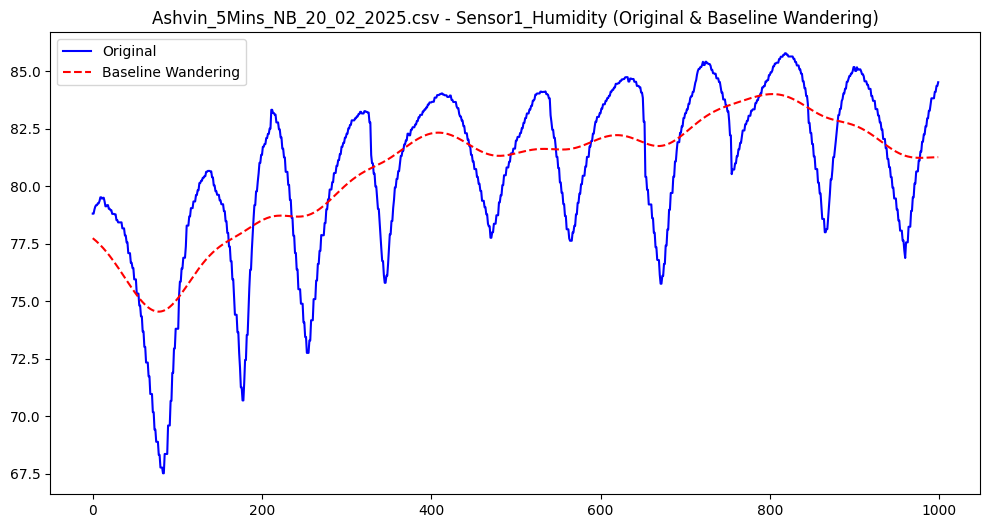

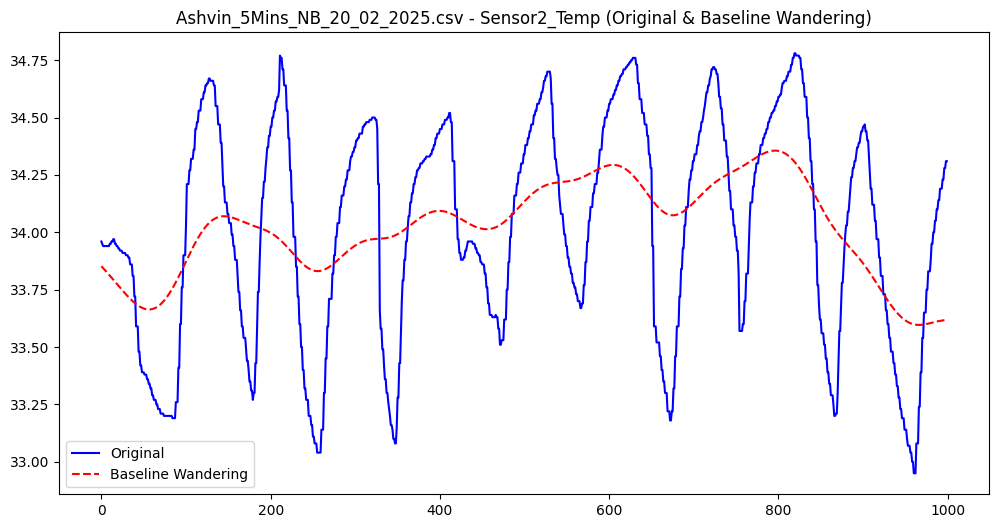

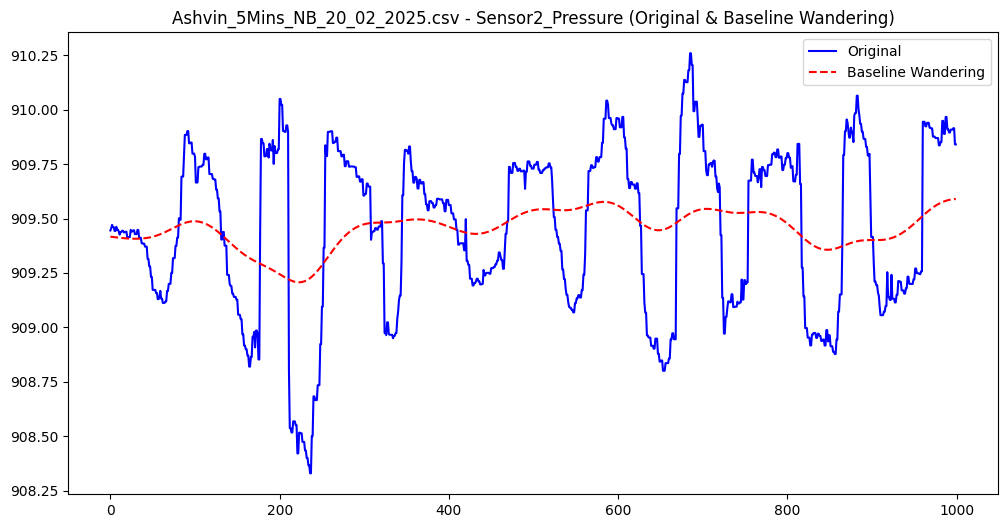

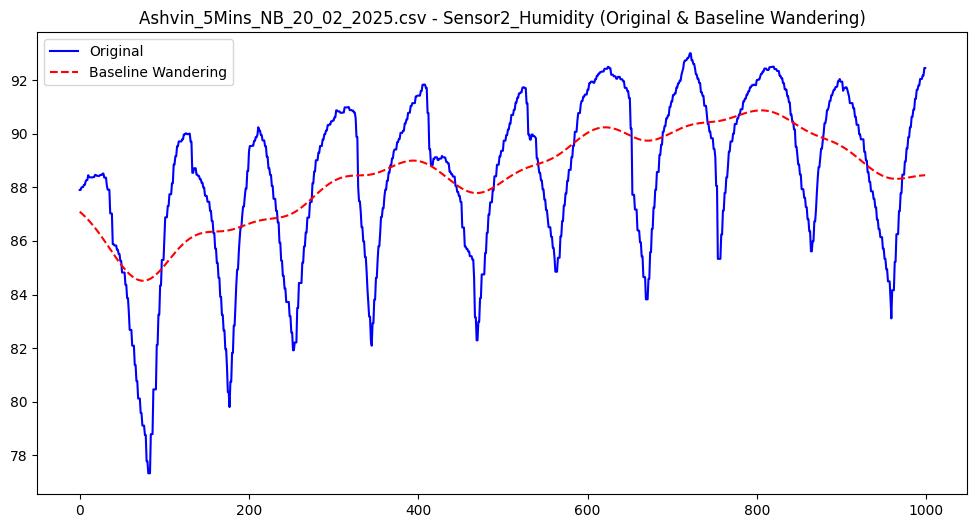

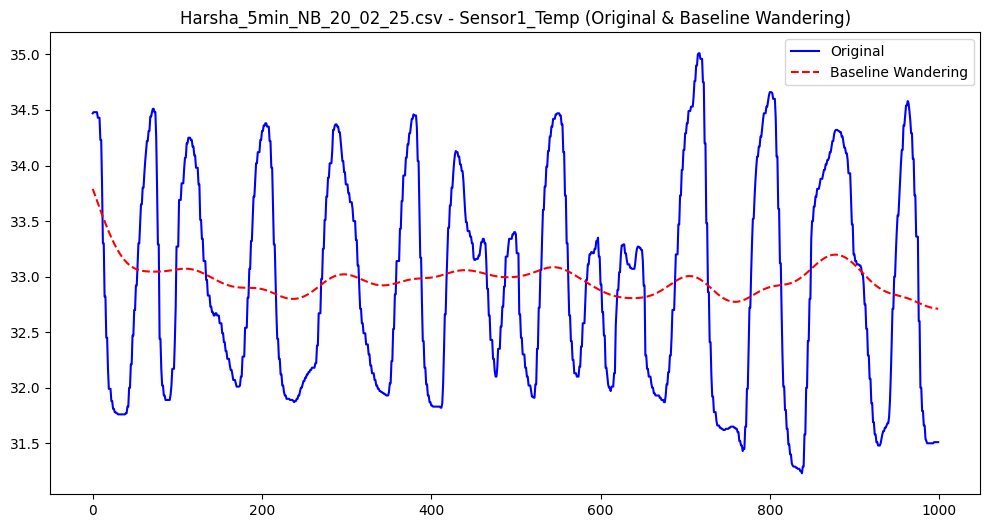

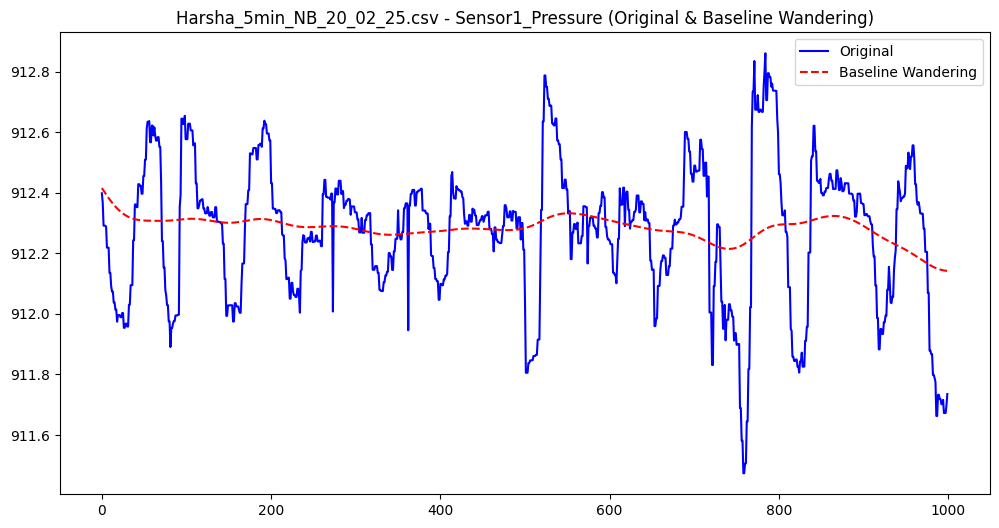

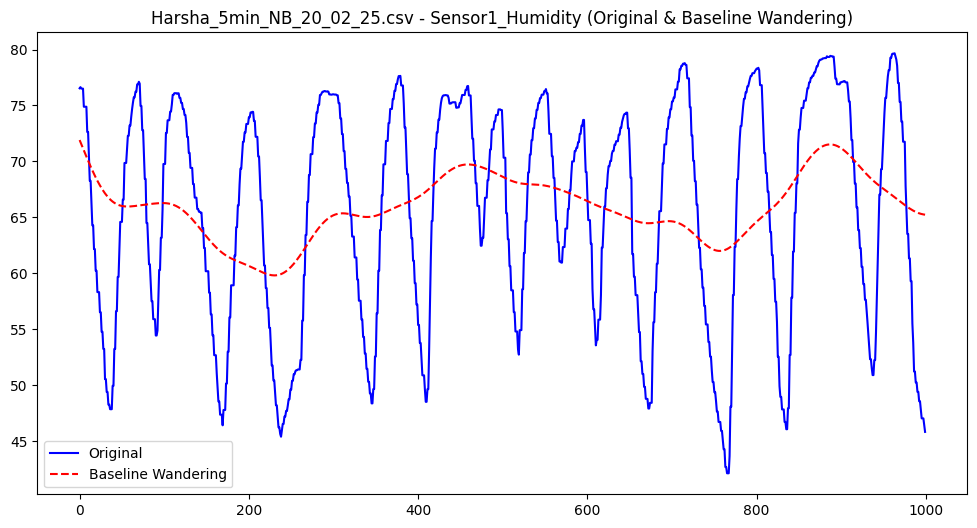

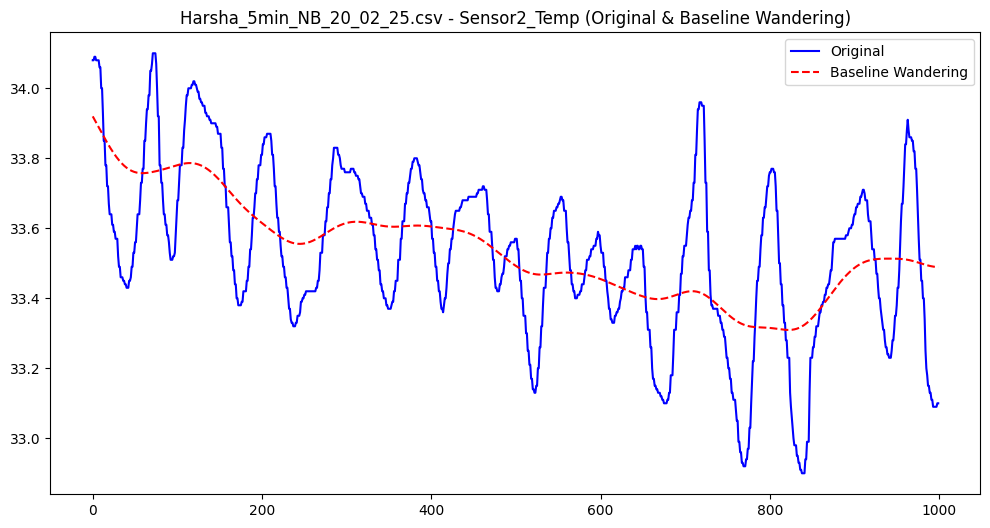

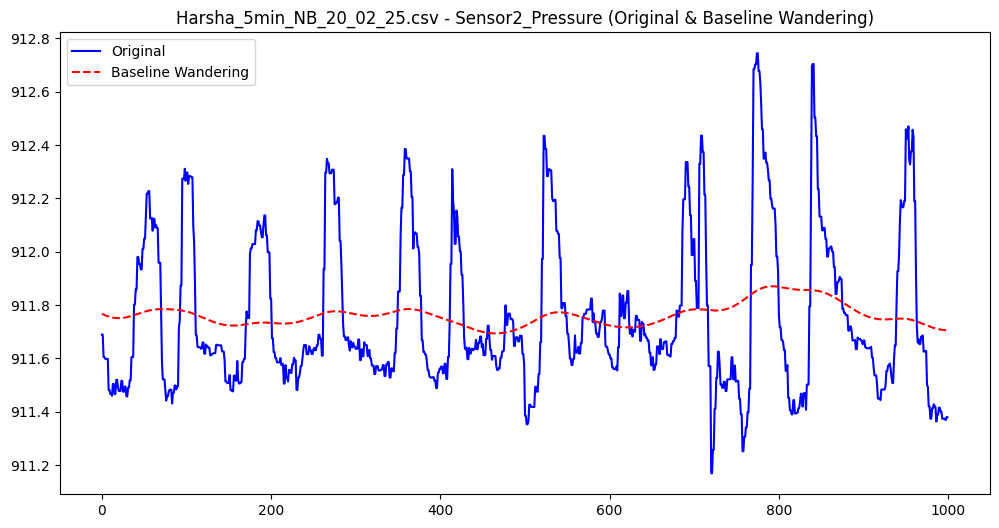

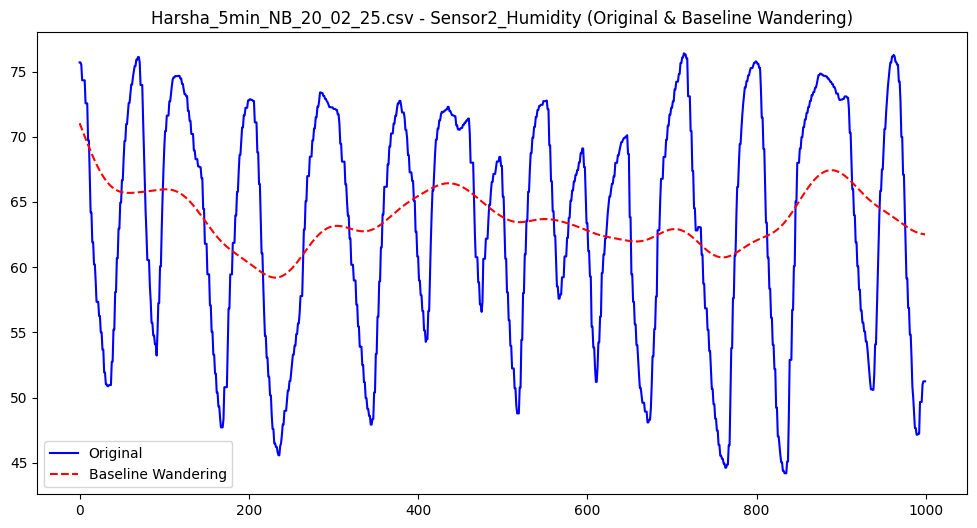

Epoch 1/100
784/784 [==============================] - 6s 6ms/step - loss: 0.0363 - mae: 0.1245 - val_loss: 9.3975e-06 - val_mae: 0.0025
Epoch 2/100
784/784 [==============================] - 4s 5ms/step - loss: 0.0099 - mae: 0.0772 - val_loss: 2.7654e-04 - val_mae: 0.0165
Epoch 3/100
784/784 [==============================] - 3s 4ms/step - loss: 0.0071 - mae: 0.0661 - val_loss: 7.8981e-06 - val_mae: 0.0023
Epoch 4/100
784/784 [==============================] - 4s 5ms/step - loss: 0.0054 - mae: 0.0576 - val_loss: 3.9556e-05 - val_mae: 0.0063
Epoch 5/100
784/784 [==============================] - 5s 7ms/step - loss: 0.0043 - mae: 0.0510 - val_loss: 8.9316e-04 - val_mae: 0.0297
Epoch 6/100
784/784 [==============================] - 4s 5ms/step - loss: 0.0036 - mae: 0.0452 - val_loss: 0.0014 - val_mae: 0.0375
Epoch 7/100
784/784 [==============================] - 4s 5ms/step - loss: 0.0032 - mae: 0.0408 - val_loss: 2.7008e-05 - val_mae: 0.0049
Epoch 8/100
784/784 [========================

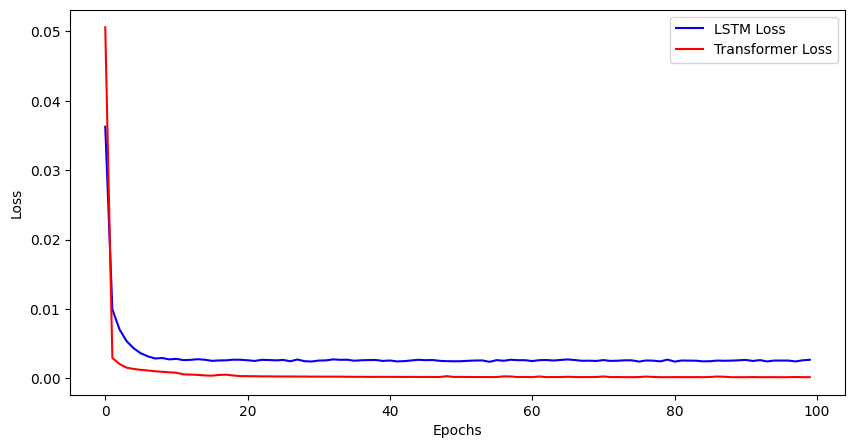

In [5]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Tkinter File Selection
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth Filters
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Remove Outliers
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if file_paths:
    dataframes = [pd.read_csv(file) for file in file_paths]
    df = pd.concat(dataframes, ignore_index=True)

    # Dataset Summary Table
    dataset_summary = pd.DataFrame({
        "File Name": [file.split("/")[-1] for file in file_paths],
        "Rows": [len(pd.read_csv(file)) for file in file_paths],
        "Columns": [len(pd.read_csv(file).columns) for file in file_paths],
    })
    print("\nDataset Information:\n", dataset_summary)

    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    if not numeric_columns:
        print("No numeric columns found.")
    else:
        for file, dataframe in zip(file_paths, dataframes):
            for col in numeric_columns:
                signal = dataframe[col].fillna(0)[:1000]  

                # Preprocessing: Filtering & Outlier Removal
                baseline_wandering = low_pass_filter(signal)
                filtered_signal = high_pass_filter(signal)
                outlier_removed_signal = remove_outliers(filtered_signal)

                # Plot 1000 samples
                plt.figure(figsize=(12, 6))
                plt.plot(signal[:1000], label="Original", color='b')
                plt.plot(baseline_wandering[:1000], label="Baseline Wandering", color='r', linestyle='dashed')
                plt.title(f"{file.split('/')[-1]} - {col} (Original & Baseline Wandering)")
                plt.legend()
                plt.show()

        # Prepare Data for Model
        scaler = MinMaxScaler()
        processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

        X, y = [], []
        seq_length = 10
        for i in range(len(processed_data) - seq_length):
            X.append(processed_data[i:i+seq_length])
            y.append(processed_data[i+seq_length])
        X, y = np.array(X), np.array(y)

        train_size = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

        # Build LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(len(numeric_columns))
        ])
        lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Build Transformer Model
        class TransformerModel(nn.Module):
            def __init__(self, input_dim):
                super(TransformerModel, self).__init__()
                self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
                self.fc = nn.Linear(input_dim, input_dim)

            def forward(self, x):
                x = self.transformer_encoder(x)
                return self.fc(x[:, -1, :])  

        transformer_model = TransformerModel(input_dim=len(numeric_columns))
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

        # Train Both Models for 100 Epochs
        num_epochs = 100
        history_lstm = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        X_train_torch = torch.tensor(X_train, dtype=torch.float32)
        y_train_torch = torch.tensor(y_train, dtype=torch.float32)
        train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

        transformer_losses = []
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                output = transformer_model(batch_X)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            transformer_losses.append(total_loss / len(train_loader))

        # Extract Model Performance at Specific Epochs
        epochs_to_check = [10, 30, 50, 75, 100]
        performance_table = []

        for epoch in epochs_to_check:
            y_pred_lstm = lstm_model.predict(X_test)
            y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

            lstm_loss = history_lstm.history['loss'][epoch-1]
            transformer_loss = transformer_losses[epoch-1]

            performance_table.append({
                "Epoch": epoch,
                "LSTM Loss": lstm_loss,
                "Transformer Loss": transformer_loss
            })

        # Convert to DataFrame and Print
        performance_df = pd.DataFrame(performance_table)
        print("\nModel Performance Table:\n", performance_df)

        # Plot 1000 Samples
        plt.figure(figsize=(10, 5))
        plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
        plt.plot(transformer_losses, label='Transformer Loss', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

else:
    print("No file selected. Please upload a valid dataset.")


In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: False
GPU Name: No GPU detected


In [4]:
import torch
print(torch.__version__)


2.6.0+cpu


In [1]:
import torch
print(torch.__version__)


2.5.1+cu121


In [2]:
x = torch.randn(10000, 10000).to("cuda")
print("GPU is working!")


GPU is working!
